In [ ]:
# finding single and double-positive cells

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# dataset 2
sc1 = readRDS('Yao_data.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
22354 features across 406187 samples within 1 assay 
Active assay: RNA (22354 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

BICCN_cluster_id QC   BICCN_cluster_label
SM-D9D8O_S03_E1-50 48               1201 L6 CT Grp_1        
SM-DAIH5_S47_E1-50 48               3678 L6 CT Grp_1        
                   BICCN_subclass_label BICCN_class_label cluster_color size
SM-D9D8O_S03_E1-50 L6 CT                Glutamatergic     #197A6E       781 
SM-DAIH5_S47_E1-50 L6 CT                Glutamatergic     #197A6E       781 
                   temp_class_label   BICCN_ontology_term_id
SM-D9D8O_S03_E1-50 GlutamatergicL6 CT ILX:0770162           
SM-DAIH5_S47_E1-50 GlutamatergicL6 CT ILX:0770162           
                   assay_ontology_term_id ⋯ tissue_type cell_type           
SM-D9D8O_S03_E1-50 EFO:0700016            ⋯ tissue      glutamatergic neuron
SM-DAIH5_S47_E1-50 EFO:0700016            ⋯ tissue      glutamatergic neuron
                   assay        disease organism     sex  tissue              
SM-D9D8O_S03_E1-50 Smart-seq v4 normal  Mus musculus male primary motor cortex
SM-DAIH5_S47_E1-50 Smart-seq v4 normal  Mus musculus male primary motor cortex
                   self_reported_ethnicity development_stage observation_joinid
SM-D9D8O_S03_E1-50 na                      prime adult stage z=_D2*y#}+        
SM-DAIH5_S47_E1-50 na                      prime adult stage 4pfr)NaU6L

In [4]:
table(mtd1$development_stage)


prime adult stage 
           406187 

In [5]:
table(mtd1$cell_type)


              endothelial cell                      astrocyte 
                          3483                          18905 
               oligodendrocyte                microglial cell 
                         21549                             55 
            smooth muscle cell                     macrophage 
                            47                           8408 
              GABAergic neuron                       pericyte 
                         61782                           1450 
          glutamatergic neuron            leptomeningeal cell 
                        282893                           2404 
oligodendrocyte precursor cell                        unknown 
                          5097                            114 

In [6]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@counts, meta.data = sc1@meta.data)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [7]:
genes = sc1@assays$RNA@meta.features$feature_name
ids = which(!is.na(genes))
exp2 = exp1[ids,]
rownames(exp2) = genes[ids]
exp2[1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
        SM-D9D8O_S03_E1-50 SM-DAIH5_S47_E1-50
Rsrc2             364.9163          194.69326
Tmem121             .                19.40004

In [8]:
sum(exp2['Neurog2',]>0)
sum(exp2['Ascl1',]>0)
sum(exp2['Neurog1',]>0)

[1] 979

[1] 25606

[1] 136

In [9]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [10]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp2, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp2, 'Neurog2', 'Neurog1')

In [11]:
# save file
saveids = which(exp2['Neurog2',]>0 | exp2['Ascl1',]>0 | exp2['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp2[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Yao_Nature_A1N1N2.rds')

[1] 26601

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
44708 features across 26601 samples within 1 assay 
Active assay: RNA (44708 features, 0 variable features)
 2 layers present: counts, data

In [25]:
gene1_exp = exp2['Neurog2',]
gene2_exp = exp2['Neurog1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [27]:
cor(vec1, vec2, method = 'spearman')

[1] 0.1315921

In [28]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp   m1_rank   m2_rank  
P12_NxCLB1_AAACCCAAGGTTCAGG 0      7.979469 0.4777732 0.7609341
P12_NxCLB1_AAACCCACAACTCGAT 0      7.845099 0.4777732 0.7461846

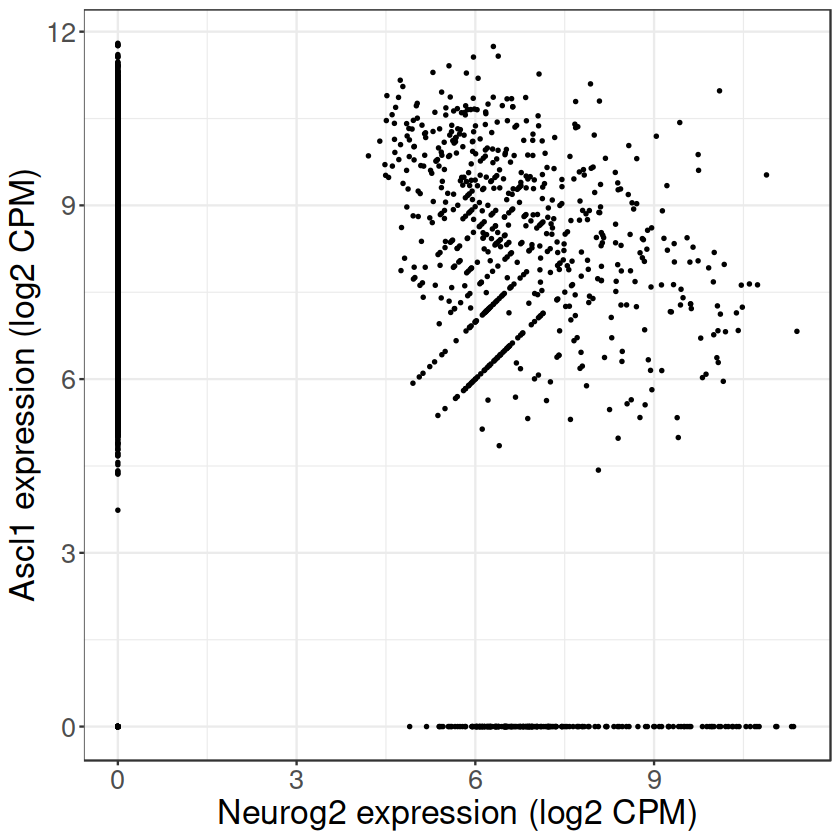

In [29]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

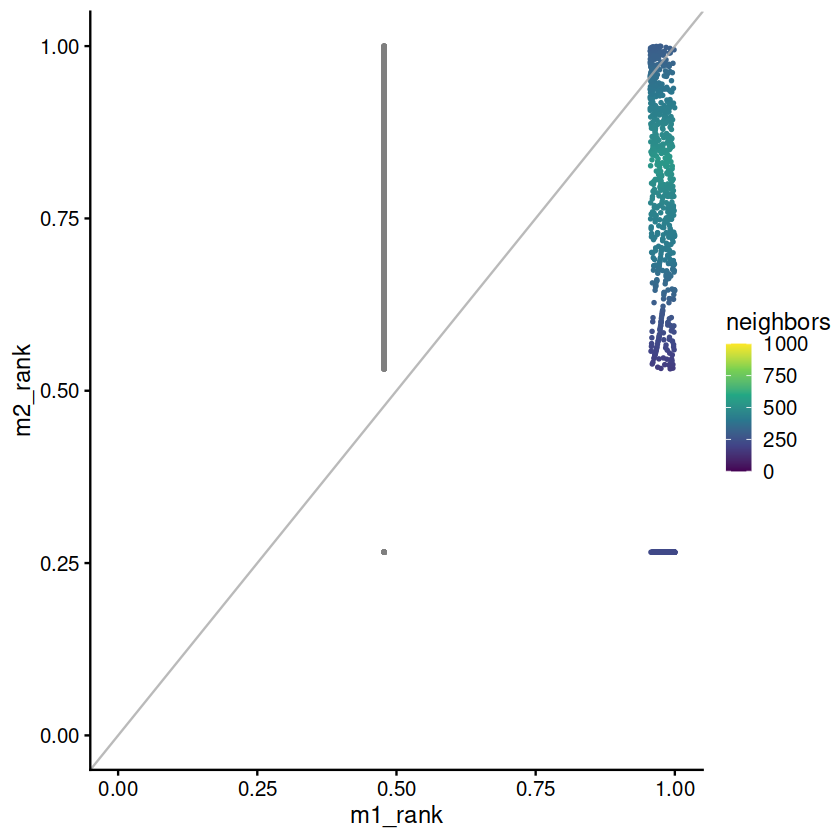

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [26]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 0

[1] 979

[1] 136

In [17]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$cell_type[id1]))


           astrocyte     GABAergic neuron glutamatergic neuron 
                   2                    1                  111 
     oligodendrocyte              unknown 
                   1                    1 

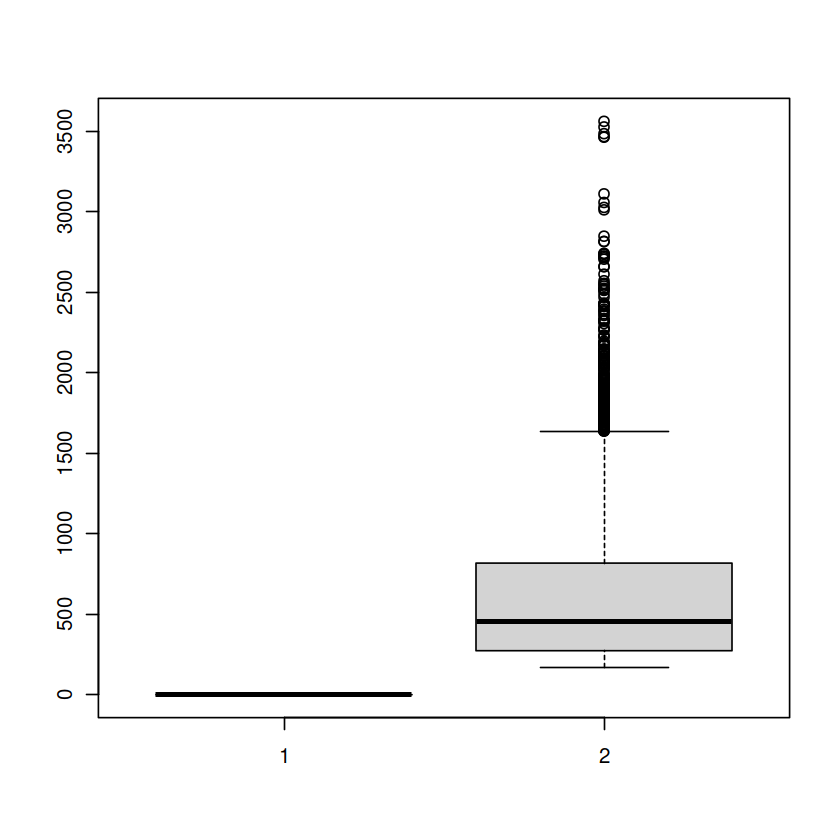

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [18]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Cacng5"

[1] 21923

[1] 4

[1] 62

[1] 3270

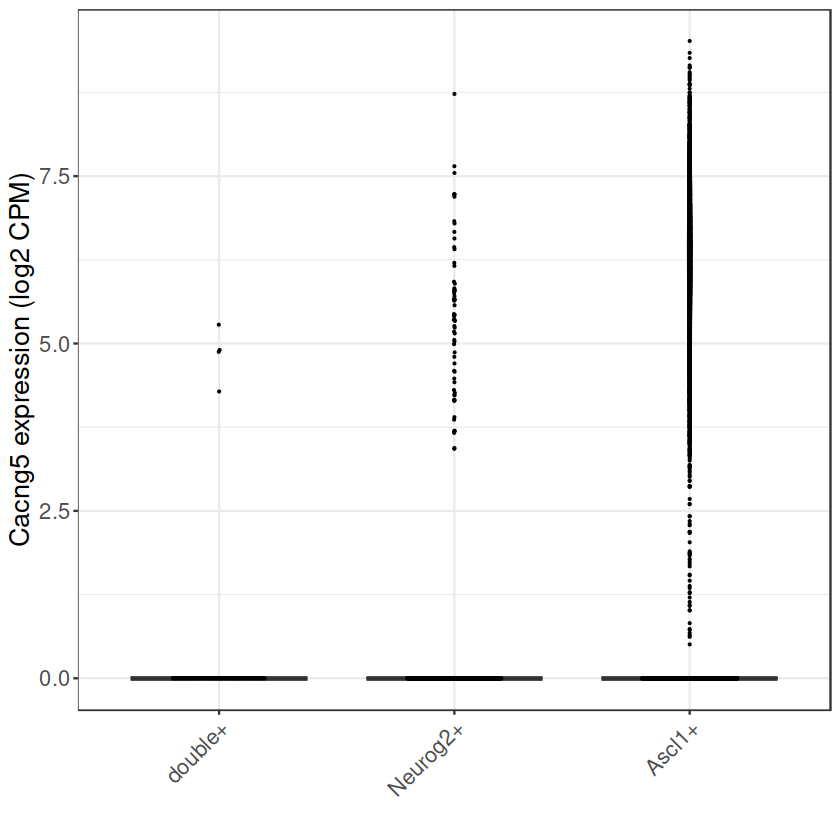

In [19]:
# other coexpressing genes
currgene = 'Cacng5'
currgene
sum(exp2[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp2[currgene, id1]>0)
sum(exp2[currgene, id2]>0)
sum(exp2[currgene, id3]>0)

exp_vec = exp2[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [20]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp2), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp2[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp2)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 22352

[1] 6558

In [22]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp2[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 226

gene   dbl_exp  gene1_exp gene2_exp retain
1 Scube1 5.396808 3.471150  3.520288  1     
2 Exph5  4.906804 2.967948  2.563805  1

In [23]:
dfnew$gene[dfnew$retain==1]

[1] "Scube1"                     "Exph5"                     
  [3] "Myo1b"                      "Adrb1"                     
  [5] "Wnt4"                       "Lhx2"                      
  [7] "Tmem259"                    "Gm20063"                   
  [9] "Spata2l"                    "Ccng2"                     
 [11] "B4galt2"                    "Slc41a2"                   
 [13] "Klhl8"                      "Sntg2"                     
 [15] "Ak4"                        "Igfbp5"                    
 [17] "Enoph1"                     "Prr12"                     
 [19] "Mpp3"                       "Prdm8"                     
 [21] "Npy1r"                      "Egr4"                      
 [23] "Crhr1"                      "Bhlhe22"                   
 [25] "Zfp941"                     "Plxnd1"                    
 [27] "Ankrd34a"                   "Rin1"                      
 [29] "Col26a1"                    "Zfp703"                    
 [31] "Tnks1bp1"                   "Hey1"                      
 [33] "Pkib"                       "Car4"                      
 [35] "Zfp9"                       "Coch"                      
 [37] "Lsm11"                      "Rnd1"                      
 [39] "Tmcc2"                      "Fem1a"                     
 [41] "Gpr88"                      "Htr7"                      
 [43] "Ctnnd1"                     "Pisd"                      
 [45] "D430019H16Rik"              "Otud1"                     
 [47] "Cep162"                     "Icmt"                      
 [49] "Hira"                       "Rgs10"                     
 [51] "Kctd12"                     "Atf6b"                     
 [53] "Atp8b2"                     "Tmem47"                    
 [55] "Ppfibp1"                    "Gna13"                     
 [57] "Net1"                       "Zfp267"                    
 [59] "Hkdc1"                      "Tle3"                      
 [61] "Mex3b"                      "Plaat1"                    
 [63] "Lingo3"                     "1700066M21Rik"             
 [65] "Dpysl4"                     "Kmt2b"                     
 [67] "Igfn1"                      "Pigs"                      
 [69] "Hsd17b7"                    "Slitrk2"                   
 [71] "Topors"                     "C130026L21Rik"             
 [73] "P2rx4"                      "Slc9a5"                    
 [75] "Akr1e1"                     "Slc25a37"                  
 [77] "Etnk2"                      "Barx2"                     
 [79] "Tmem215"                    "Chrd"                      
 [81] "Anxa11"                     "Abcc8"                     
 [83] "A330009N23Rik"              "Ccdc3"                     
 [85] "Nr2f6"                      "Zfp763"                    
 [87] "Klf16"                      "Pot1a"                     
 [89] "Atg14"                      "Hif1an"                    
 [91] "Pitrm1"                     "Naf1"                      
 [93] "Mfsd5"                      "Glra3"                     
 [95] "Xrcc5"                      "Sertm1"                    
 [97] "Pepd"                       "Kcnj11"                    
 [99] "Gne"                        "Gca"                       
[101] "Hpcal1"                     "Twsg1"                     
[103] "Synm"                       "Lrrn1"                     
[105] "Msantd3"                    "Zbtb46"                    
[107] "Ehbp1l1"                    "Lyrm7"                     
[109] "C130074G19Rik"              "Adcyap1"                   
[111] "Cebpb"                      "Neurl1b"                   
[113] "Akr1b3"                     "Traf3ip1"                  
[115] "Ercc8"                      "Pomk"                      
[117] "Nelfa"                      "Fbn2"                      
[119] "Nek6"                       "Hdac6"                     
[121] "Mrps2"                      "Ruvbl1"                    
[123] "Adnp2"                      "Tmem209"                   
[125] "Zbtb34"                    

In [24]:
# df for saving
write.table(dfnew, file = 'yao_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

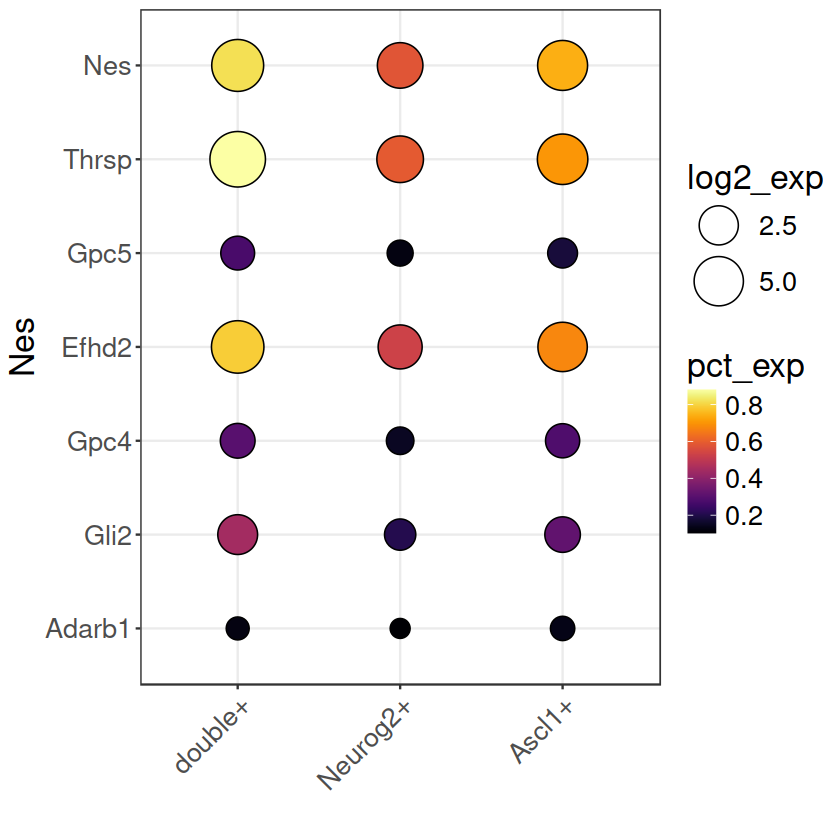

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()